# 🛒 Análise Exploratória de Dados — E-commerce Brasileiro (Olist)

## 📌 Contexto
Este notebook realiza uma Análise Exploratória de Dados (EDA) a partir de dados reais
de um e-commerce brasileiro, com o objetivo de identificar padrões de vendas,
comportamento de clientes, desempenho logístico e sua relação com a satisfação do consumidor.

O dataset utilizado é o *Brazilian E-Commerce Public Dataset by Olist*, disponível publicamente no Kaggle.

## 🎯 Objetivos da Análise
- Compreender a evolução das vendas ao longo do tempo  
- Identificar categorias de produtos mais relevantes  
- Avaliar o impacto da logística na satisfação do cliente  
- Gerar insights acionáveis para tomada de decisão

Imports e Configuração Visual

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


Carregamento dos Dados

In [71]:
path = '../data/raw/'

orders = pd.read_csv(path + 'olist_orders_dataset.csv')
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')



In [72]:
datasets = {
    'orders': orders,
    'customers': customers,
    'order_items': order_items,
    'products': products,
    'payments': payments,
    'reviews': reviews
}

for name, df in datasets.items():
    print(f'{name}: {df.shape}')


orders: (99441, 8)
customers: (99441, 5)
order_items: (112650, 7)
products: (32951, 9)
payments: (103886, 5)
reviews: (99224, 7)


Conversão de Datas

In [73]:
date_cols_orders = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_cols_orders:
    orders[col] = pd.to_datetime(orders[col])


Integração das Tabelas (Base Analítica)

In [74]:
df = (
    orders
    .merge(customers, on='customer_id', how='left')
    .merge(order_items, on='order_id', how='left')
    .merge(products, on='product_id', how='left')
    .merge(payments, on='order_id', how='left')
    .merge(reviews[['order_id', 'review_score']], on='order_id', how='left')
)


# Base Analítica

A base analítica foi construída a partir da integração das principais tabelas do dataset,
permitindo análises combinadas de pedidos, clientes, produtos, pagamentos e avaliações.


## Criação de Métricas de Negócio

Nesta etapa, são definidas métricas fundamentais para a análise,
permitindo avaliar desempenho financeiro, comportamento de compra
e apoiar análises temporais e comparativas.


Criação de Métricas

Receita por Item

In [75]:
df['revenue'] = df['price'] + df['freight_value']
df[['price', 'freight_value', 'revenue']].head()


,price,freight_value,revenue
0,29.99,8.72,38.71
1,29.99,8.72,38.71
2,29.99,8.72,38.71
3,118.70,22.76,141.46
4,159.90,19.22,179.12


Receita total

In [76]:
df['revenue'].sum()


np.float64(16643731.3)

Ticket médio por pedido

In [77]:
ticket_medio = df.groupby('order_id')['revenue'].sum().mean()
ticket_medio


np.float64(167.372927665651)

# Preparação Temporal dos Dados

Nesta etapa, as colunas de data são convertidas para o formato adequado,
permitindo análises temporais e cálculos de prazos de entrega.

In [78]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

📊 12️⃣ Análise Temporal
Pedidos ao longo do tempo

In [79]:
orders_time = (
    orders
    .set_index('order_purchase_timestamp')
    .resample('ME')
    .size()
)


Evolução do Volume de Pedidos ao Longo do Tempo

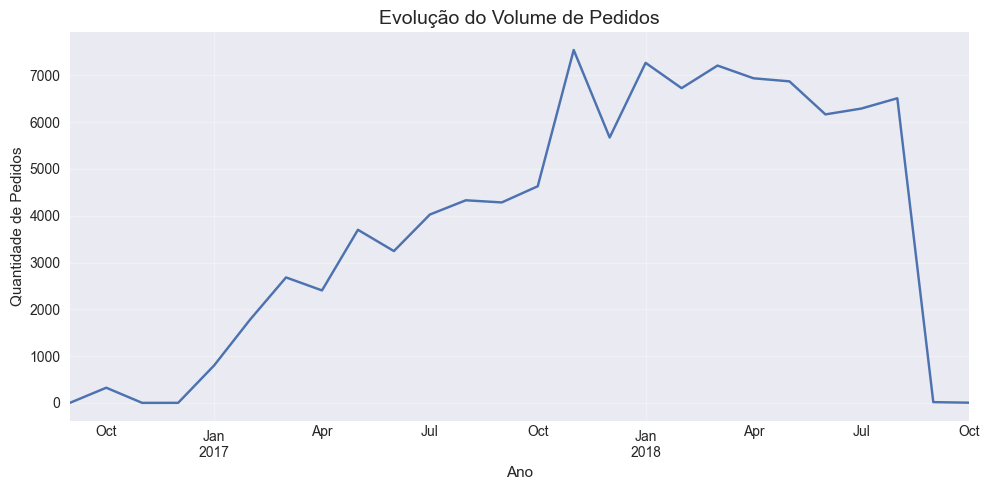

In [90]:
orders_time.plot()
plt.title('Evolução do Volume de Pedidos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Pedidos')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('../images/pedidos_tempo.png', dpi=150, bbox_inches='tight')
plt.show()




## Análise Temporal de Receita

Nesta etapa, analisamos a evolução da receita ao longo do tempo,
buscando identificar tendências de crescimento e padrões sazonais.

## Receita mensal

In [81]:
receita_mensal = (
    df
    .set_index('order_purchase_timestamp')
    .resample('ME')['revenue']
    .sum()
)


### Evolução da Receita Mensal

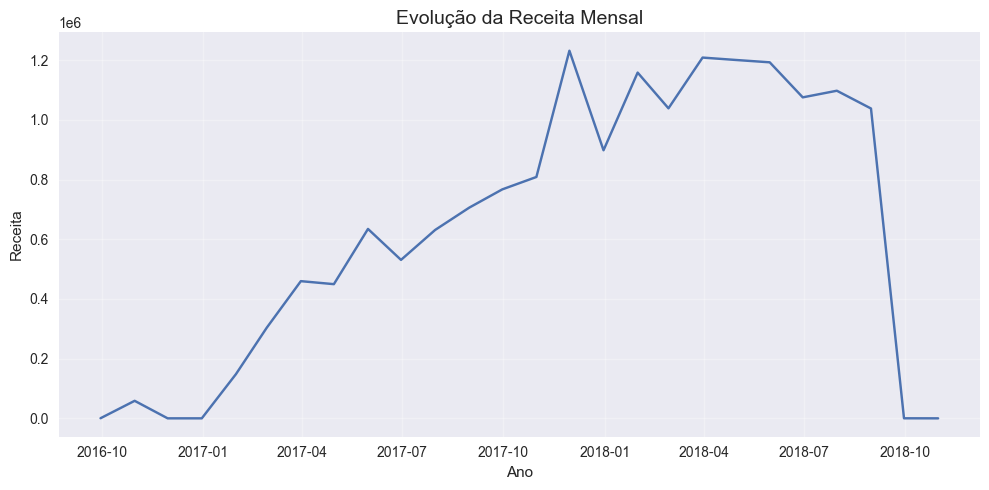

In [91]:
plt.plot(receita_mensal)
plt.title('Evolução da Receita Mensal')
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('../images/receita_mensal.png', dpi=150, bbox_inches='tight')
plt.show()



## Logística e Satisfação do Cliente

Nesta seção, analisamos o impacto do tempo de entrega
na satisfação do cliente.


In [83]:
df['delivery_time'] = (
    df['order_delivered_customer_date'] -
    df['order_purchase_timestamp']
).dt.days

df = df[df['delivery_time'] >= 0]


### Relação entre Tempo de Entrega e Avaliação


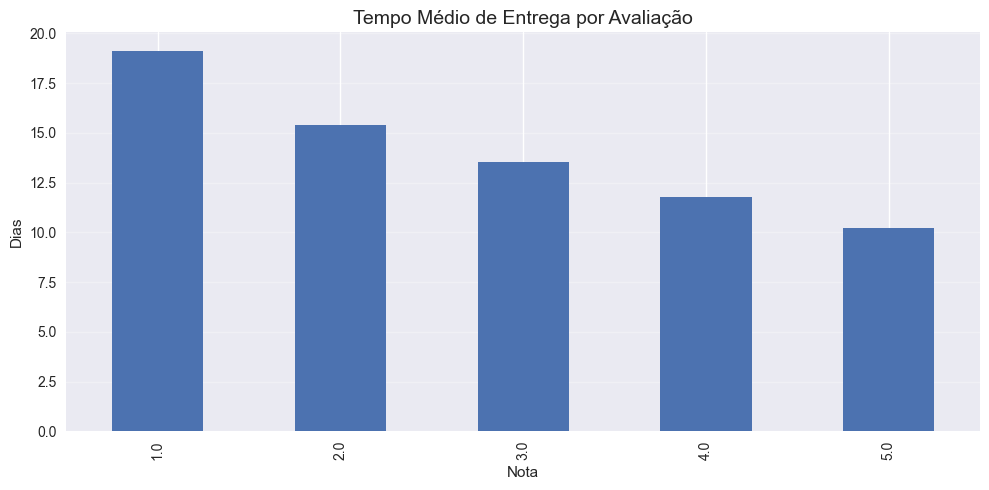

In [92]:
media_entrega_avaliacao.plot(kind='bar')
plt.title('Tempo Médio de Entrega por Avaliação')
plt.xlabel('Nota')
plt.ylabel('Dias')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('../images/entrega_avaliacao.png', dpi=150, bbox_inches='tight')
plt.show()



**Insight:**  
Pedidos com maior tempo de entrega tendem a receber
avaliações mais baixas, evidenciando a logística como
fator crítico para a satisfação do cliente.

## Análise por Categoria de Produto

Nesta etapa, avaliamos o desempenho das categorias de produtos
em termos de volume de pedidos e receita.

Tratamento de categorias nulas

In [85]:
df['product_category_name'] = df['product_category_name'].fillna('outros')


Volume por categoria (Top 10)

In [86]:
pedidos_categoria = (
    df.groupby('product_category_name')['order_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)


### Top 10 Categorias por Volume de Pedidos

Gráfico categorias (volume)

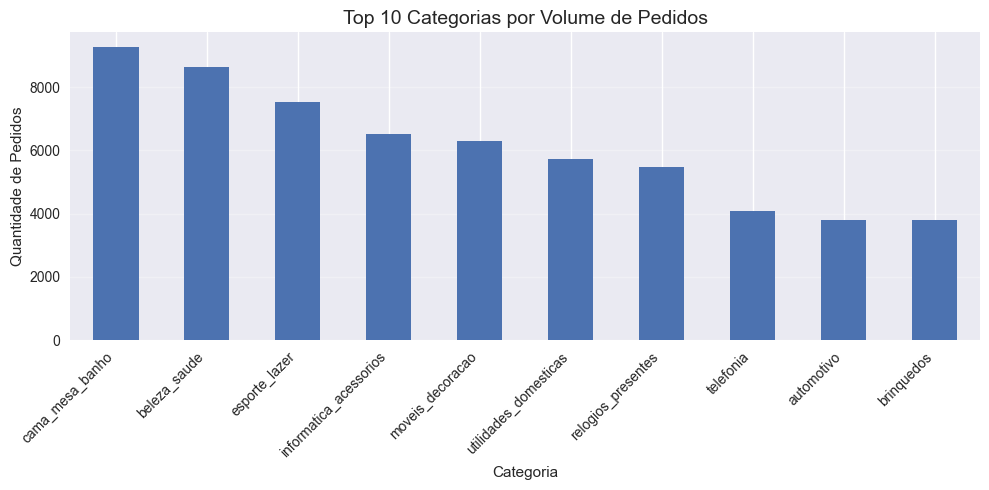

In [87]:
pedidos_categoria.plot(kind='bar')
plt.title('Top 10 Categorias por Volume de Pedidos')
plt.xlabel('Categoria')
plt.ylabel('Quantidade de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Top 10 Categorias por Receita

Receita por categoria

In [88]:
receita_categoria = (
    df.groupby('product_category_name')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)


Gráfico categorias (receita)

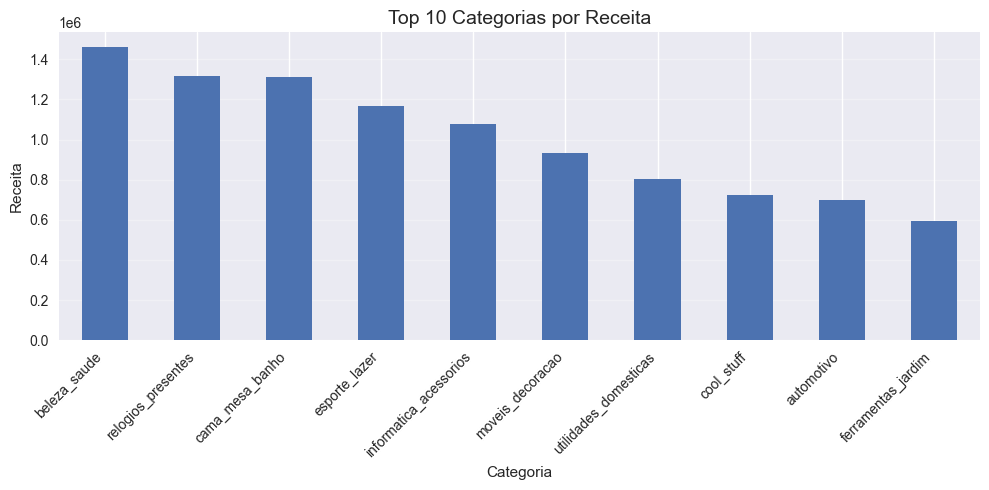

In [93]:
receita_categoria.plot(kind='bar')
plt.title('Top 10 Categorias por Receita')
plt.xlabel('Categoria')
plt.ylabel('Receita')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('../images/categorias_receita.png', dpi=150, bbox_inches='tight')
plt.show()



### Insights por Categoria

- Algumas categorias possuem alto volume de vendas, mas menor receita,
  indicando produtos de menor ticket médio.
- Outras categorias apresentam menor volume, porém maior receita,
  sugerindo produtos de maior valor agregado.

## Conclusão

A análise exploratória permitiu identificar padrões relevantes de vendas,
comportamento dos clientes e impacto da logística na satisfação.
Esses insights podem apoiar decisões estratégicas em operações
e experiência do cliente.


## Conclusão Executiva

A análise exploratória dos dados do e-commerce brasileiro (Olist) permitiu identificar
padrões relevantes de vendas, comportamento dos clientes e impactos operacionais
no nível de satisfação.

Ao longo do período analisado, observou-se um crescimento consistente no volume
de pedidos e na receita, com variações sazonais que indicam maior atividade
em determinados meses do ano.

A análise por categoria evidenciou que algumas categorias concentram alto volume
de pedidos, porém com menor valor agregado, enquanto outras apresentam menor
frequência de vendas, mas maior contribuição para a receita total.

No aspecto logístico, foi identificado que pedidos com maior tempo de entrega
tendem a receber avaliações mais baixas, reforçando a logística como um fator
crítico para a experiência do cliente e a percepção de qualidade do serviço.

De forma geral, os resultados demonstram que decisões relacionadas à melhoria
dos prazos de entrega, otimização do mix de produtos e planejamento baseado
em sazonalidade podem gerar impactos positivos tanto na receita quanto
na satisfação dos clientes.